# Fine-tuning LayoutLM for document-understanding using Keras & Hugging Face Transformers 

In this blog, you will learn how to fine-tune [LayoutLM (v1)](https://huggingface.co/docs/transformers/model_doc/layoutlm) for document-understand using Tensorflow, Keras & Hugging Face Transformers. LayoutLM is a document image understanding and information extraction transformers and was originally published by Microsoft Research as PyTorch model, which was later converted to Keras by the Hugging Face Team. LayoutLM (v1) is the only model in the LayoutLM family with an MIT-license, which allows it to be used for commercial purposes compared to other LayoutLMv2/LayoutLMv3. 

We will use the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset a collection of 199 fully annotated forms. More information for the dataset can be found at the [dataset page](https://guillaumejaume.github.io/FUNSD/).

You will learn how to:

1. [Setup Development Environment](#1-setup-development-environment)
2. [Load and prepare FUNSD dataset](#2-load-and-prepare-funsd-dataset)
3. [Fine-tune and evaluate LayoutLM](#3-fine-tune-and-evaluate-layoutlm)
4. [Run inference and parse form](#4-run-inference-and-parse-form)

Before we can start, make sure you have a [Hugging Face Account](https://huggingface.co/join) to save artifacts and experiments. 

## Quick intro: LayoutLM by Microsoft Research

LayoutLM is a multimodal Transformer model for document image understanding and information extraction transformers and can be used form understanding and receipt understanding. 

![donut](./layoutlm.png)

* Paper: https://arxiv.org/pdf/1912.13318.pdf
* Official repo:  https://github.com/microsoft/unilm/tree/master/layoutlm

--- 

Now we know how LayoutLM works, so let's get started. 🚀

_Note: This tutorial was created and run on a g4dn.xlarge AWS EC2 Instance including a NVIDIA T4._



## 1. Setup Development Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following cell will install all the required packages. 
Additinoally, we need to install an OCR-library to extract text from images. We will use [pytesseract](https://pypi.org/project/pytesseract/).

If you haven't set up a Tensorflow environment you can use the `conda` snippet below. 

```bash
conda create --channel=conda-forge --name tf \
  python=3.9 \
  nvidia::cudatoolkit=11.2 \
  tensorflow=2.10.0=*cuda112*py39* 
```

In [ ]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets evaluate seqeval tensorboard

In [ ]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account, you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load and prepare FUNSD dataset

We will use the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset a collection of 199 fully annotated forms. The dataset is available on Hugging Face at [nielsr/funsd](https://huggingface.co/datasets/nielsr/funsd). 

_Note: The LayoutLM model doesn't have a `AutoProcessor` to create the our input documents, but we can use the `LayoutLMv2Processor` instead._  

In [1]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

To load the `funsd` dataset, we use the `load_dataset()` method from the 🤗 Datasets library.


In [2]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Found cached dataset funsd (/home/ubuntu/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595)


  0%|          | 0/2 [00:00<?, ?it/s]

Train dataset size: 149
Test dataset size: 50


Lets checkout an example of the dataset.

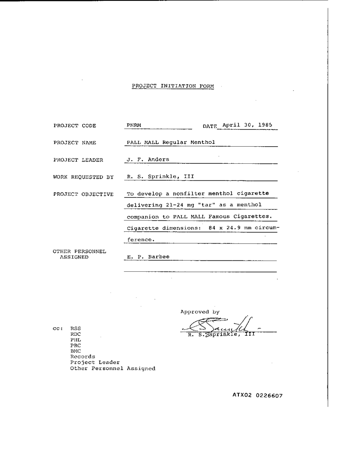

In [17]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][40]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

We can display all our classes by inspecting the features of our dataset. Those `ner_tags` will be later used to create a user friendly output after we fine-tuned our model.

In [4]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


To train our model we need to convert our inputs (text/image) to token IDs. This is done by a 🤗 Transformers Tokenizer and PyTesseract. If you are not sure what this means check out [chapter 6](https://huggingface.co/course/chapter6/1?fw=tf) of the Hugging Face Course.

In [5]:
from transformers import LayoutLMv2Processor

# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

Before we can process our dataset we need to define the `features` or the processed inputs, which are later based into the model. Features are a special dictionary that defines the internal structure of a dataset.
Compared to traditional NLP datasets we need to add the `bbox` feature, which is a 2D array of the bounding boxes for each token. 

In [6]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
)

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])


Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595/cache-27b50144d8bd996a.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595/cache-7c2616060c62016d.arrow


dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


## 3. Fine-tune and evaluate LayoutLM

After we have processed our dataset, we can start training our model. Therefore we first need to load the [microsoft/layoutlm-base-uncased](https://huggingface.co/microsoft/layoutlm-base-uncased) model with the `TFLayoutLMForTokenClassification` class with the label mapping of our dataset. 



In [7]:
from transformers import TFLayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"

# load model with correct number of labels and mapping
model = TFLayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

2022-10-10 12:26:13.026391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 12:26:13.109695: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-10 12:26:14.830651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 12:26:14.842519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA no

Before we can train our model we have todefine the hyperparameters we want to use for our training. Therefore will create a `dataclass`. 

In [8]:
from dataclasses import dataclass
from huggingface_hub import HfFolder
import tensorflow as tf


@dataclass
class Hyperparameters:
    num_train_epochs: int = 8
    train_batch_size: int = 8
    eval_batch_size: int = 8
    learning_rate: float = 3e-5
    weight_decay_rate: float = 0.01
    output_dir: str = 'layoutlm-funsd-tf'
    hub_model_id: str = f'layoutlm-funsd-tf'
    hub_token: str = HfFolder.get_token()  # or your token directly "hf_xxx"
    fp16 = True
    # Train in mixed-precision float16
    def __post_init__(self):
        if self.fp16:
            tf.keras.mixed_precision.set_global_policy("mixed_float16")
            
hp = Hyperparameters()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


2022-10-10 12:26:17.811747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


The next step is to convert our dataset to a `tf.data.Dataset` this can be done by the `model.prepare_tf_dataset`. 

In [9]:
# prepare train dataset
tf_train_dataset = model.prepare_tf_dataset(
    proc_dataset["train"],
    batch_size=hp.train_batch_size,
    shuffle=True,
)

# prepare test dataset
tf_test_dataset = model.prepare_tf_dataset(
    proc_dataset["test"],
    batch_size=hp.eval_batch_size,
    shuffle=False,
)

As mentioned in the beginning we want to use the [Hugging Face Hub](https://huggingface.co/models) for model versioning and monitoring. Therefore we want to push our model weights, during training and after training to the Hub to version it. Additionally, we want to track the performance during training therefore we will push the `Tensorboard` logs along with the weights to the Hub to use the "Training Metrics" Feature to monitor our training in real-time.

Additionally, we are going to use the `KerasMetricCallback` from the `transformers` library to evaluate our model during training using `seqeval` and `evaluate`. The `KerasMetricCallback` allows us to compute metrics at the end of every epoch. It is particularly useful for common NLP metrics, like BLEU and ROUGE as well as for class specific `f1` scores, like `seqeval` provides.

In [10]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    res = metric.compute(predictions=[all_predictions], references=[all_labels])
    return {
        "overall_precision": res["overall_precision"],
        "overall_recall": res["overall_recall"],
        "overall_f1": res["overall_f1"],
        "overall_accuracy": res["overall_accuracy"],
    }


We can add all our callbacks to a list which we then provide to the `model.fit` method. We are using the following callbacks:

* `TensorBoard`: To log our training metrics to Tensorboard
* `PushToHubCallback`: To push our model weights and Tensorboard logs to the Hub
* `KerasMetricCallback`: To evaluate our model during training

In [11]:
import os
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback

callbacks = []

callbacks.append(TensorboardCallback(log_dir=os.path.join(hp.output_dir, "logs")))
callbacks.append(KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_test_dataset))

if hp.hub_token:
    callbacks.append(PushToHubCallback(output_dir=hp.output_dir, hub_model_id=hp.hub_model_id, hub_token=hp.hub_token))


Cloning https://huggingface.co/philschmid/layoutlm-funsd-tf into local empty directory.


Before we can start our training we have to create the optimizer and compile our model. 

In [12]:
import tensorflow as tf
from transformers import AdamWeightDecay

# create optimizer width weigh decay
optimizer = AdamWeightDecay(
    learning_rate = hp.learning_rate,
    weight_decay_rate = hp.weight_decay_rate,
)

# compile model
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


We can ttart training with calling `model.fit` providing the training and validation dataset, along with the hyperparameters, optimizer, metrics and callbacks we defined before.



In [13]:
# train model
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_test_dataset,
    callbacks=callbacks,
    epochs=hp.num_train_epochs,
)

Epoch 1/8
18/18 [==============================] - ETA: 0s - loss: 1.6940

/home/ubuntu/miniconda/envs/tf/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 [==============================] - 47s 2s/step - loss: 1.6940 - val_loss: 1.4151 - overall_precision: 0.2686 - overall_recall: 0.2785 - overall_f1: 0.2735 - overall_accuracy: 0.5128
Epoch 2/8
18/18 [==============================] - 20s 1s/step - loss: 1.1731 - val_loss: 0.8665 - overall_precision: 0.5771 - overall_recall: 0.6101 - overall_f1: 0.5932 - overall_accuracy: 0.7267
Epoch 3/8
18/18 [==============================] - 40s 2s/step - loss: 0.7612 - val_loss: 0.6849 - overall_precision: 0.6362 - overall_recall: 0.7336 - overall_f1: 0.6814 - overall_accuracy: 0.7784
Epoch 4/8
18/18 [==============================] - 20s 1s/step - loss: 0.5630 - val_loss: 0.6265 - overall_precision: 0.6748 - overall_recall: 0.7592 - overall_f1: 0.7145 - overall_accuracy: 0.8017
Epoch 5/8
18/18 [==============================] - 40s 2s/step - loss: 0.4441 - val_loss: 0.6256 - overall_precision: 0.6935 - overall_recall: 0.7767 - overall_f1: 0.7328 - overall_accuracy: 0.8036
Epoch 6/8
18/18 [===

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file tf_model.h5:   0%|          | 32.0k/430M [00:00<?, ?B/s]

Upload file logs/train/events.out.tfevents.1665404784.ip-172-31-95-43.58711.0.v2:   1%|1         | 32.0k/2.13M…

Upload file logs/validation/events.out.tfevents.1665404814.ip-172-31-95-43.58711.1.v2: 100%|##########| 1.25k/…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/philschmid/layoutlm-funsd-tf
   465f984..626d523  main -> main



Nice, we have trained our model. 🎉 The best score we achieved is an overall f1 score of `0.7534`.

![layout_training](./tensorboard.png)

After our training is done we also want to save our processor to the Hugging Face Hub and create a model card. 

In [14]:

# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True
# Save processor and create model card
model.push_to_hub(hp.hub_model_id, use_auth_token=hp.hub_token)
processor.push_to_hub(hp.hub_model_id, use_auth_token=hp.hub_token)

CommitInfo(commit_url='https://huggingface.co/philschmid/layoutlm-funsd-tf/commit/25274563ffd189893ded7bc403aa098aef5468b6', commit_message='Upload processor', commit_description='', oid='25274563ffd189893ded7bc403aa098aef5468b6', pr_url=None, pr_revision=None, pr_num=None)

## 4. Run Inference

Now we have a trained model, we can use it to run inference. We will create a function that takes a document image and returns the extracted text and the bounding boxes.

Some layers from the model checkpoint at philschmid/layoutlm-funsd-tf were not used when initializing TFLayoutLMForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFLayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLayoutLMForTokenClassification were initialized from the model checkpoint at philschmid/layoutlm-funsd-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLayoutLMForTokenClassification for predictions without further training.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


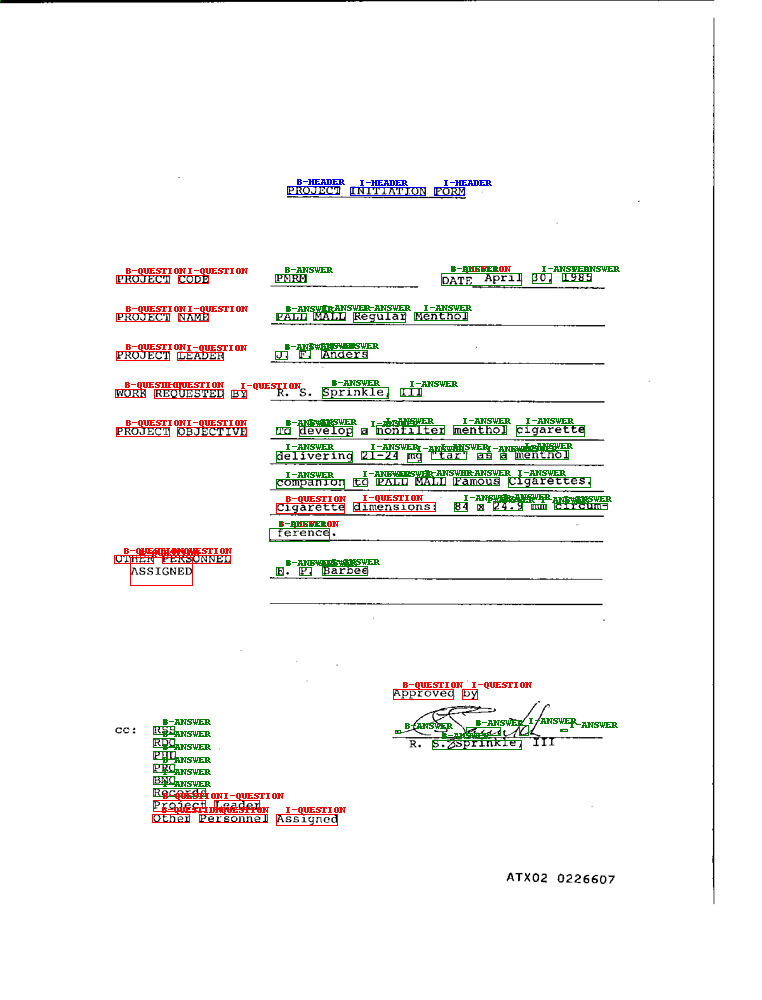

In [18]:
from transformers import TFLayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf 

# load model and processor from huggingface hub
model = TFLayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd-tf")
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd-tf")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="tf")
    del encoding["image"]
    # run inference
    outputs = model(**encoding)
    predictions = tf.squeeze(tf.argmax(outputs.logits, axis=-1)).numpy()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset['train'][40]["image_path"])


## Conclusion

We managed to successfully fine-tune our LayoutLM to extract information from forms. With only `149` training examples we achieved an overall f1 score of `0.7534`, which is impressive and another prove for the power of transfer learning. 

Now its your time to integrate Transformers into your own projects. 🚀 